# Demo of Ch7. Dimension Reduction
----
This is the sample code of TU-ETP-AD1062 Machine Learning Fundamentals.

For more information, please refer to:
https://sites.google.com/view/tu-ad1062-mlfundamentals/

## Import packages
----
- `sklearn`: Scikit-Learn, provides basic data analysis and machine learning methods functionality
    - `decomposition.PCA`: Provides the functionality of Principal Component Analysis (PCA)
    - `discriminant_analysis.LinearDiscriminantAnalysis`: Provides the functionality of Linear Discriminant Analysis (LDA)
    - `manifold.TSNE`:Provides the functionality of t-Distributed Stochastic Neighbor Embedding (t-SNE)
- `keras`: Keras framework, provides as a unified deep learning front-end, can be integrated with Tensorflow, CNTK ., etc.
    - `dataset.mnist`: MNIST dataset
    - `layers.*`: Layers component for autoencoder
    - `models.Model`: For constructing Keras model

In [1]:
import numpy as np

from keras.datasets import mnist, fashion_mnist
from keras.layers import Input, Dense
from keras.models import Model

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from mlfund.plot import Plot2D, Plot3D

%matplotlib inline

Using TensorFlow backend.


## Load Dataset
----
The **MNIST** database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

For more information, see: http://yann.lecun.com/exdb/mnist/

The **Fashion MNIST** is a dataset of Zalando's article images - consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms.

For more information, see: https://github.com/zalandoresearch/fashion-mnist

> **Tips:** You can directly change `mnist.load_data()` to `fashion_mnist.load_data()`

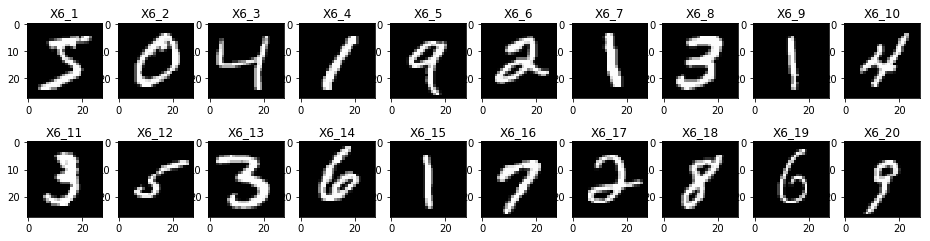

In [2]:
(I_train, y_train), (I_test, y_test) = mnist.load_data()

plt.figure(figsize=(16, 4))
for i in range(0, 20):
    plt.subplot(2, 10, i+1)
    plt.imshow(I_train[i, :], cmap='gray')
    
    plt.title("X6_%d" % (i + 1))

In [3]:
X_train = np.array(I_train).reshape(len(I_train), 784) / 255.0
y_train = np.array(y_train)

X_test = np.array(I_test).reshape(len(I_test), 784) / 255.0
y_test = np.array(y_test)

X6 = X_train[y_train == 6]
print("Total data of class 6: %d" % len(X6))

Total data of class 6: 5918


## Overview

### Demo 7.0.1 Autoencoder
----
The demo here shows the unexplained bases trained from the encoder parts of autoencoder.

In [4]:
encoding_dim = 64

def build_autoencoder():
    input_img = Input(shape=(784,))
    
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)

    # Auto-Encoder
    autoencoder = Model(input_img, decoded)

    # Encoder
    encoder = Model(input_img, encoded)

    # Decoder
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder, encoder, decoder

In [5]:
autoencoder, encoder, decoder = build_autoencoder()

autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 44us/step - loss: 0.3501 - val_loss: 0.2683
Epoch 2/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.2580 - val_loss: 0.2436
Epoch 3/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.2317 - val_loss: 0.2186
Epoch 4/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.2116 - val_loss: 0.2026
Epoch 5/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.1977 - val_loss: 0.1905
Epoch 6/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.1870 - val_loss: 0.1811
Epoch 7/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.1784 - val_loss: 0.1733
Epoch 8/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.1712 - val_loss: 0.1667
Epoch 9/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.1651 - val_loss: 0.1608
Epoch

The code snippet here shows:
- The original images of `X_test`, and
- The reconstructed images of `X_test` as `X_test_predict`. Notice that it can be viewed as:
    - Encodes the `X_test` into low-dimensional (here we use `encoding_dim=64`) latent variables
    - Then decodes the low-dimensional latent variables back to the reconstructed images `X_test_predict`

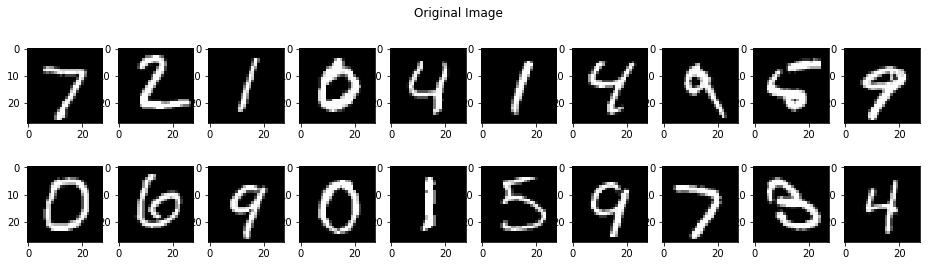

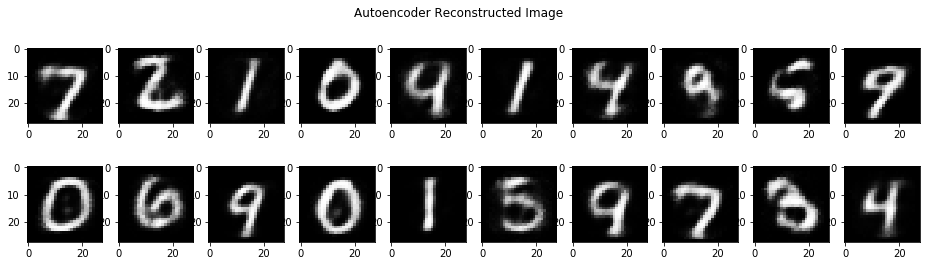

In [6]:
# Show original images
plt.figure(figsize=(16, 4))
plt.suptitle('Original Image')
for i in range(0, 20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test[i, :].reshape(28, 28), cmap='gray')

# Show reconstructed images from autoencoder
X_test_predict = autoencoder.predict(X_test)
    
plt.figure(figsize=(16, 4))
plt.suptitle('Autoencoder Reconstructed Image')
for i in range(0, 20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test_predict[i, :].reshape(28, 28), cmap='gray')

The code snippet here shows the bases images, which is used for representing all 784 dimension images

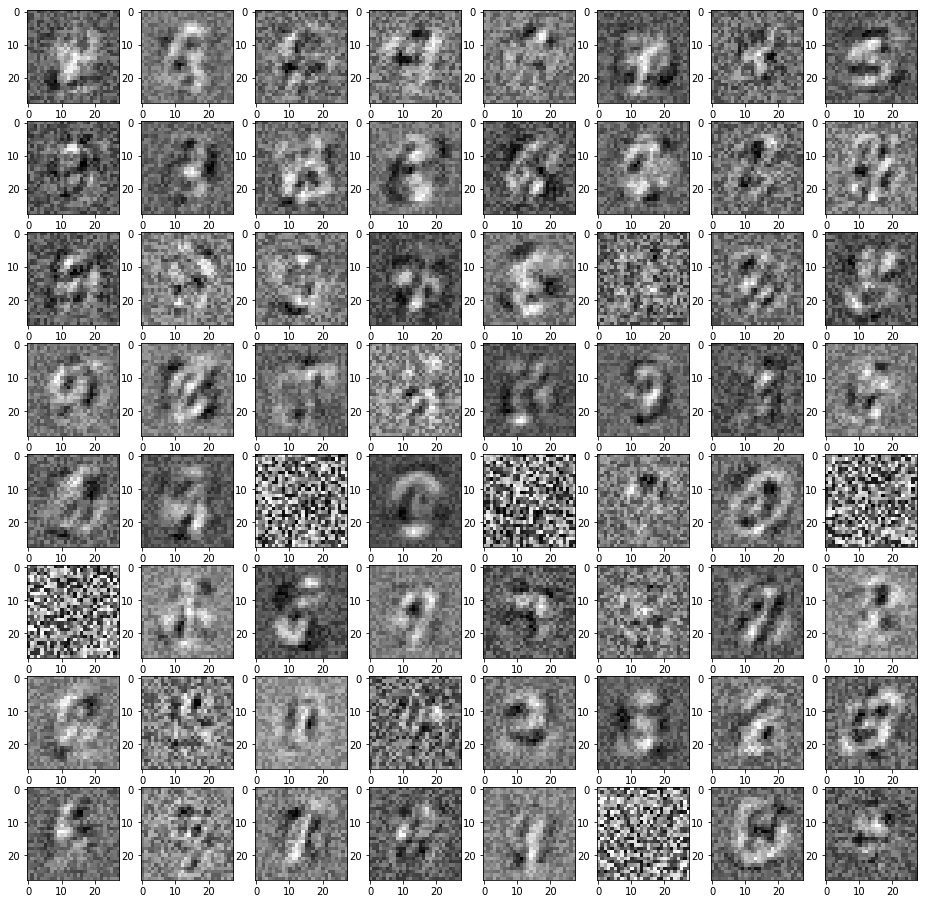

In [7]:
N_filters = encoder.layers[1].get_weights()[0].shape[-1]
weights   = encoder.layers[1].get_weights()[0]

plt.figure(figsize=(16, 16))
for i in range(0, N_filters):
    plt.subplot(int(np.ceil(N_filters/8)), 8, i+1)
    
    w_i = encoder.layers[1].get_weights()[0][:, i]
    plt.imshow( np.array(w_i).reshape(28, 28), cmap='gray')

## 7.1. Principal Component Analysis (PCA)

### Demo 7.1.1 PCA on MNIST
----
The demo here conduct Principal Component Analysis on MNIST dataset, with data of class 6 only
1. Load the MNIST data with `target==6` first
2. Conduct dimension reduction with only 40 base preserved
3. Show all eigenvectors and its corresponded eigenvalue trends
4. Show the reconstruction results by the eigenvectors

Text(0.5, 1.0, 'Square root of Eigenvalues')

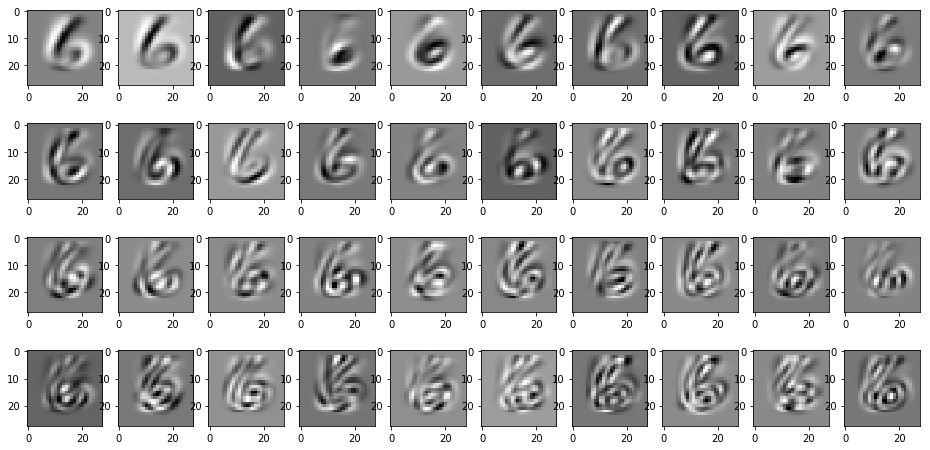

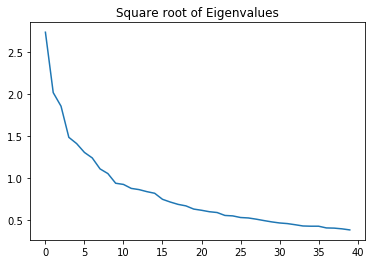

In [8]:
n_components=40

pca = PCA(n_components=n_components)
pca.fit( X6 )
X6_pca = pca.transform( X6 )

plt.figure(figsize=(16, 8))
for i in range(0, n_components):
    plt.subplot(n_components/10, 10, i+1)
    plt.imshow(pca.components_[i, :].reshape((28,28)), cmap='gray')

plt.figure()
plt.plot(np.sqrt(pca.explained_variance_))
plt.title('Square root of Eigenvalues')

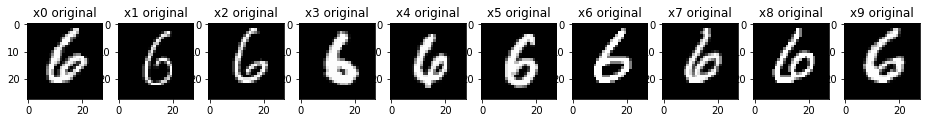

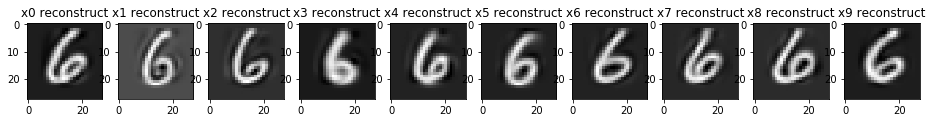

In [9]:
X6_recon = pca.inverse_transform(X6_pca)

plt.figure(figsize=(16, 4))
for i in range(0, 10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X6[i, :].reshape((28,28)), cmap='gray')
    plt.title('x%d original' % i)
    
plt.figure(figsize=(16, 4))
for i in range(0, 10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X6_recon[i, :].reshape((28,28)), cmap='gray')
    plt.title('x%d reconstruct' % i)


### Demo 7.1.2 Visualization for Low-dimensional Latent Variables of PCA
----
The demo here conduct Principal Component Analysis on MNIST dataset, with partial (5%) data considered
1. Load the MNIST first, with only 5% (`p=[0.95, 0.05]`) data selected for visualization purposes
2. Conduct dimension reduction with only 3 base preserved
3. Plot the scatter of the selected data

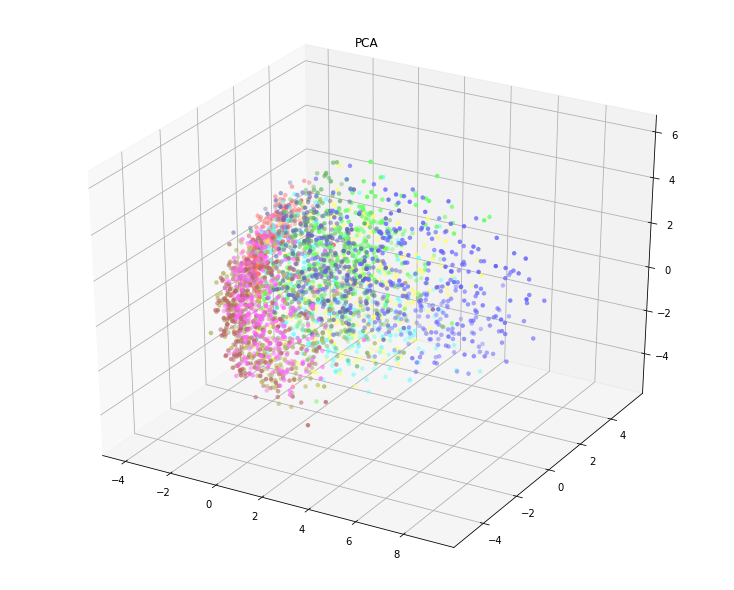

In [10]:
n_components=40

X = X_train
y = y_train

idx = np.random.choice(a=[False, True], size=len(X), p=[0.95, 0.05])
X = X[idx, :]
y = y[idx]

pca = PCA(n_components=3)
pca.fit( X )
X_pca = pca.transform( X )

plot = Plot3D()
plot.scatter(X_pca, y)
plot.title('PCA')
plot.show()

## 7.2. Linear Discriminant Analysis

### Demo 7.2.1 Visualization for Low-dimensional Latent Variables of PCA
----
The demo here conducts Linear Discriminant Analysis on MNIST dataset, with partial (5%) data considered, then plot the scatter.

c:\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Github\tu-etp-ad1062\mlfund\plot.py:72: UserWarning: Dimension of samples exceeds 3, only plot the first-3 dimension
  warnings.warn("Dimension of samples exceeds 3, only plot the first-3 dimension")


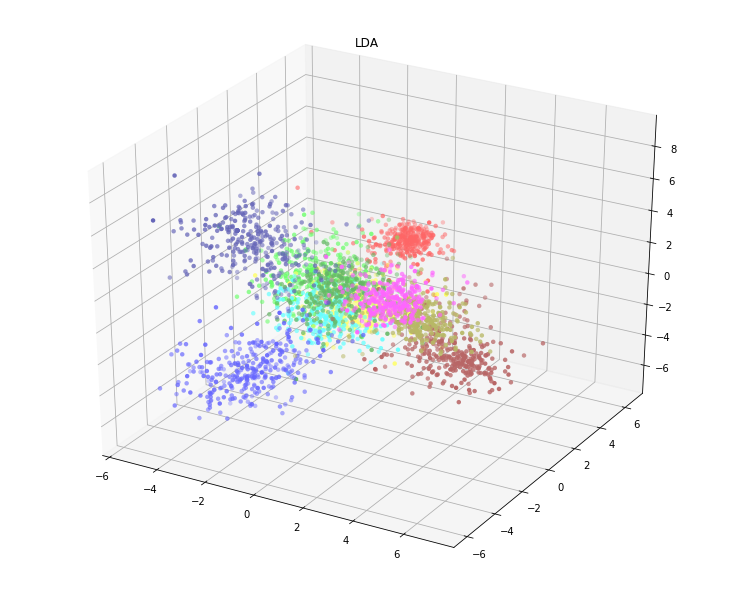

In [11]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

X_lda = lda.transform(X)

plot = Plot3D()
plot.scatter(X_lda, y)
plot.title('LDA')
plot.show()

## 7.3. t-distributed Stochastic Neighboring Embedding (t-SNE)

### 7.3.1 Visualization for Low-dimensional Latent Variables of t-SNE
----
The demo here conducts t-distributed Stochastic Neighboring Embedding (t-SNE) on MNIST dataset, with partial (5%) data considered.

Notice that for the performance concern, the t-SNE requires conducting PCA on original data first. Therefore the `X_pca` is used.

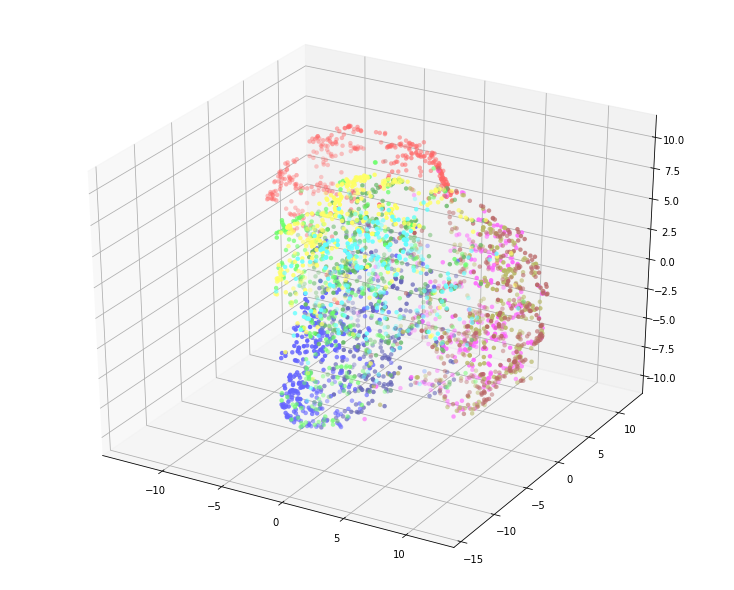

In [12]:
tSNE = TSNE(n_components=3)
X_tSNE = tSNE.fit_transform(X_pca) 

plot = Plot3D()
plot.scatter(X_tSNE, y)
plot.show()